# LSTM for a sequential problem

# Stock prediction LSTM trial 1

In [ ]:
import torch
import pandas as pd
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('https://raw.githubusercontent.com/CNielsen94/NN_exercises_AAUBSDS/main/Assignment%202%20-%20CNN%20and%20RNN/AAPL_2006-01-01_to_2018-01-01.csv', parse_dates=True)

In [ ]:
df.head()

,Date,Open,High,Low,Close,Volume,Name
0,2006-01-03,10.34,10.68,10.32,10.68,201853036,AAPL
1,2006-01-04,10.73,10.85,10.64,10.71,155225609,AAPL
2,2006-01-05,10.69,10.70,10.54,10.63,112396081,AAPL
3,2006-01-06,10.75,10.96,10.65,10.90,176139334,AAPL
4,2006-01-09,10.96,11.03,10.82,10.86,168861224,AAPL


In [ ]:
price = df[['Close']]
scaler = MinMaxScaler(feature_range=(-1, 1))
price['Close'] = scaler.fit_transform(price['Close'].values.reshape(-1,1))

<ipython-input-81-f87f87249f99>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  price['Close'] = scaler.fit_transform(price['Close'].values.reshape(-1,1))


In [85]:
def split_data(stock, lookback):
    data_raw = stock.to_numpy() # convert to numpy array
    data = []
    
    # create all possible sequences of length seq_len
    for index in range(len(data_raw) - lookback): 
        data.append(data_raw[index: index + lookback])
    
    data = np.array(data);
    test_set_size = int(np.round(0.2*data.shape[0]));
    train_set_size = data.shape[0] - (test_set_size);
    
    x_train = data[:train_set_size,:-1,:]
    y_train = data[:train_set_size,-1,:]
    
    x_test = data[train_set_size:,:-1]
    y_test = data[train_set_size:,-1,:]
    
    return [x_train, y_train, x_test, y_test]
lookback = 20 # choose sequence length
x_train, y_train, x_test, y_test = split_data(price, lookback)

In [ ]:
x_train.shape

(2399, 19, 1)

In [111]:
y_test.shape

torch.Size([600, 1])

In [86]:
import torch
import torch.nn as nn
x_train = torch.from_numpy(x_train).type(torch.Tensor)
x_test = torch.from_numpy(x_test).type(torch.Tensor)
y_train_lstm = torch.from_numpy(y_train).type(torch.Tensor)
y_test_lstm = torch.from_numpy(y_test).type(torch.Tensor)
y_train_gru = torch.from_numpy(y_train).type(torch.Tensor)
y_test_gru = torch.from_numpy(y_test).type(torch.Tensor)

In [ ]:
input_dim = 1
hidden_dim = 32
num_layers = 2
output_dim = 1
num_epochs = 100

In [ ]:
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        out = self.fc(out[:, -1, :]) 
        return out

In [ ]:
model = LSTM(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)
criterion = torch.nn.MSELoss(reduction='mean')
optimiser = torch.optim.Adam(model.parameters(), lr=0.01)

In [ ]:
import time
hist = np.zeros(num_epochs)
start_time = time.time()
lstm = []
for t in range(num_epochs):
    y_train_pred = model(x_train)
    loss = criterion(y_train_pred, y_train_lstm)
    print("Epoch ", t, "MSE: ", loss.item())
    hist[t] = loss.item()
    optimiser.zero_grad()
    loss.backward()
    optimiser.step()
    
training_time = time.time()-start_time
print("Training time: {}".format(training_time))

Epoch  0 MSE:  0.44535133242607117
Epoch  1 MSE:  0.3005008399486542
Epoch  2 MSE:  0.17682316899299622
Epoch  3 MSE:  0.16387684643268585
Epoch  4 MSE:  0.15952567756175995
Epoch  5 MSE:  0.12230903655290604
Epoch  6 MSE:  0.11530262231826782
Epoch  7 MSE:  0.11259371042251587
Epoch  8 MSE:  0.09592148661613464
Epoch  9 MSE:  0.06459174305200577
Epoch  10 MSE:  0.04328412562608719
Epoch  11 MSE:  0.05651869997382164
Epoch  12 MSE:  0.021419594064354897
Epoch  13 MSE:  0.015260989777743816
Epoch  14 MSE:  0.0282930638641119
Epoch  15 MSE:  0.0212029330432415
Epoch  16 MSE:  0.01025786530226469
Epoch  17 MSE:  0.01811319962143898
Epoch  18 MSE:  0.020720500499010086
Epoch  19 MSE:  0.011130235157907009
Epoch  20 MSE:  0.005678669083863497
Epoch  21 MSE:  0.007389917504042387
Epoch  22 MSE:  0.009990015998482704
Epoch  23 MSE:  0.010029508732259274
Epoch  24 MSE:  0.008257998153567314
Epoch  25 MSE:  0.006904073990881443
Epoch  26 MSE:  0.0072076087817549706
Epoch  27 MSE:  0.00831155385

In [ ]:
predict = pd.DataFrame(scaler.inverse_transform(y_train_pred.detach().numpy()))
original = pd.DataFrame(scaler.inverse_transform(y_train_lstm.detach().numpy()))

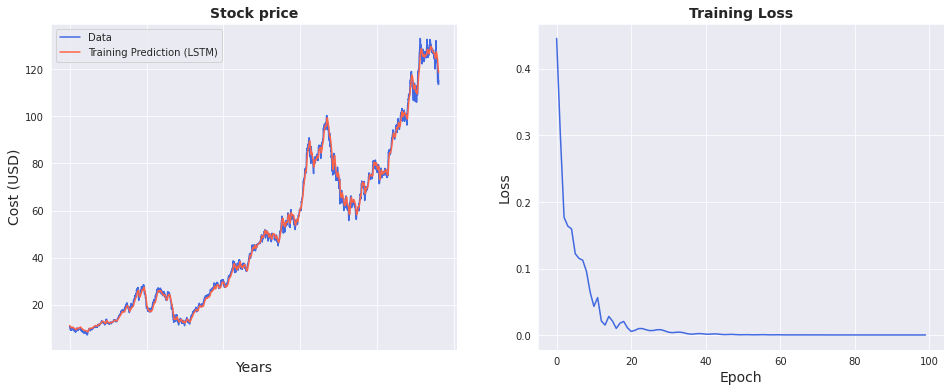

In [ ]:
import seaborn as sns
sns.set_style("darkgrid")    

fig = plt.figure()
fig.subplots_adjust(hspace=0.2, wspace=0.2)

plt.subplot(1, 2, 1)
ax = sns.lineplot(x = original.index, y = original[0], label="Data", color='royalblue')
ax = sns.lineplot(x = predict.index, y = predict[0], label="Training Prediction (LSTM)", color='tomato')
ax.set_title('Stock price', size = 14, fontweight='bold')
ax.set_xlabel("Years", size = 14)
ax.set_ylabel("Cost (USD)", size = 14)
ax.set_xticklabels('', size=10)


plt.subplot(1, 2, 2)
ax = sns.lineplot(data=hist, color='royalblue')
ax.set_xlabel("Epoch", size = 14)
ax.set_ylabel("Loss", size = 14)
ax.set_title("Training Loss", size = 14, fontweight='bold')
fig.set_figheight(6)
fig.set_figwidth(16)

In [ ]:
# Save the trained RNN model
# CODE TO SAVE THE ABOVE MODEL
torch.save(lstm.state_dict(), 'lstm.pt')

# Load the model
rnn = nn.LSTM(input_size, hidden_size, batch_first=True)
rnn.load_state_dict(torch.load('lstm.pt'))

AttributeError: ignored

# Stock prediction LSTM trial 2, 16 hidden size + 30 epochs

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('https://raw.githubusercontent.com/CNielsen94/NN_exercises_AAUBSDS/main/Assignment%202%20-%20CNN%20and%20RNN/AAPL_2006-01-01_to_2018-01-01.csv', parse_dates=True)

In [ ]:
df.head()

,Date,Open,High,Low,Close,Volume,Name
0,2006-01-03,10.34,10.68,10.32,10.68,201853036,AAPL
1,2006-01-04,10.73,10.85,10.64,10.71,155225609,AAPL
2,2006-01-05,10.69,10.70,10.54,10.63,112396081,AAPL
3,2006-01-06,10.75,10.96,10.65,10.90,176139334,AAPL
4,2006-01-09,10.96,11.03,10.82,10.86,168861224,AAPL


In [ ]:
price = df[['Close']]
scaler = MinMaxScaler(feature_range=(-1, 1))
price['Close'] = scaler.fit_transform(price['Close'].values.reshape(-1,1))

<ipython-input-4-f87f87249f99>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  price['Close'] = scaler.fit_transform(price['Close'].values.reshape(-1,1))


In [ ]:
def split_data(stock, lookback):
    data_raw = stock.to_numpy() # convert to numpy array
    data = []
    
    # create all possible sequences of length seq_len
    for index in range(len(data_raw) - lookback): 
        data.append(data_raw[index: index + lookback])
    
    data = np.array(data);
    test_set_size = int(np.round(0.2*data.shape[0]));
    train_set_size = data.shape[0] - (test_set_size);
    
    x_train = data[:train_set_size,:-1,:]
    y_train = data[:train_set_size,-1,:]
    
    x_test = data[train_set_size:,:-1]
    y_test = data[train_set_size:,-1,:]
    
    return [x_train, y_train, x_test, y_test]
lookback = 20 # choose sequence length
x_train, y_train, x_test, y_test = split_data(price, lookback)

In [ ]:
import torch
import torch.nn as nn
x_train = torch.from_numpy(x_train).type(torch.Tensor)
x_test = torch.from_numpy(x_test).type(torch.Tensor)
y_train_lstm = torch.from_numpy(y_train).type(torch.Tensor)
y_test_lstm = torch.from_numpy(y_test).type(torch.Tensor)
y_train_gru = torch.from_numpy(y_train).type(torch.Tensor)
y_test_gru = torch.from_numpy(y_test).type(torch.Tensor)

In [ ]:
input_dim = 1
hidden_dim = 16
num_layers = 2
output_dim = 1
num_epochs = 30

In [ ]:
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        out = self.fc(out[:, -1, :]) 
        return out

In [ ]:
model = LSTM(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)
criterion = torch.nn.MSELoss(reduction='mean')
optimiser = torch.optim.Adam(model.parameters(), lr=0.01)

In [ ]:
import time
hist = np.zeros(num_epochs)
start_time = time.time()
lstm = []
for t in range(num_epochs):
    y_train_pred = model(x_train)
    loss = criterion(y_train_pred, y_train_lstm)
    print("Epoch ", t, "MSE: ", loss.item())
    hist[t] = loss.item()
    optimiser.zero_grad()
    loss.backward()
    optimiser.step()
    
training_time = time.time()-start_time
print("Training time: {}".format(training_time))

Epoch  0 MSE:  0.5189822316169739
Epoch  1 MSE:  0.39137962460517883
Epoch  2 MSE:  0.28676143288612366
Epoch  3 MSE:  0.20421385765075684
Epoch  4 MSE:  0.1538531631231308
Epoch  5 MSE:  0.15223823487758636
Epoch  6 MSE:  0.18098223209381104
Epoch  7 MSE:  0.1864984631538391
Epoch  8 MSE:  0.16896598041057587
Epoch  9 MSE:  0.14595429599285126
Epoch  10 MSE:  0.12884508073329926
Epoch  11 MSE:  0.12033604830503464
Epoch  12 MSE:  0.11746544390916824
Epoch  13 MSE:  0.11552000790834427
Epoch  14 MSE:  0.11042885482311249
Epoch  15 MSE:  0.09953408688306808
Epoch  16 MSE:  0.08206526190042496
Epoch  17 MSE:  0.06079729273915291
Epoch  18 MSE:  0.044221095740795135
Epoch  19 MSE:  0.041017863899469376
Epoch  20 MSE:  0.04311787709593773
Epoch  21 MSE:  0.035147517919540405
Epoch  22 MSE:  0.021250462159514427
Epoch  23 MSE:  0.013160940259695053
Epoch  24 MSE:  0.016090361401438713
Epoch  25 MSE:  0.024184973910450935
Epoch  26 MSE:  0.027910375967621803
Epoch  27 MSE:  0.024746492505073

In [ ]:
predict = pd.DataFrame(scaler.inverse_transform(y_train_pred.detach().numpy()))
original = pd.DataFrame(scaler.inverse_transform(y_train_lstm.detach().numpy()))

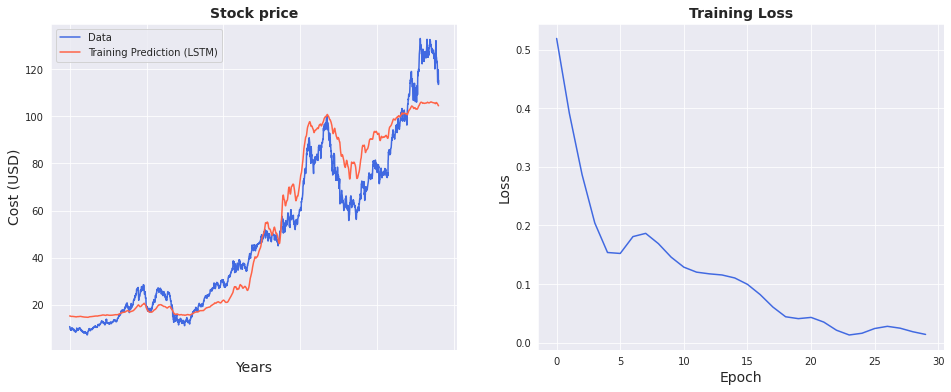

In [ ]:
import seaborn as sns
sns.set_style("darkgrid")    

fig = plt.figure()
fig.subplots_adjust(hspace=0.2, wspace=0.2)

plt.subplot(1, 2, 1)
ax = sns.lineplot(x = original.index, y = original[0], label="Data", color='royalblue')
ax = sns.lineplot(x = predict.index, y = predict[0], label="Training Prediction (LSTM)", color='tomato')
ax.set_title('Stock price', size = 14, fontweight='bold')
ax.set_xlabel("Years", size = 14)
ax.set_ylabel("Cost (USD)", size = 14)
ax.set_xticklabels('', size=10)


plt.subplot(1, 2, 2)
ax = sns.lineplot(data=hist, color='royalblue')
ax.set_xlabel("Epoch", size = 14)
ax.set_ylabel("Loss", size = 14)
ax.set_title("Training Loss", size = 14, fontweight='bold')
fig.set_figheight(6)
fig.set_figwidth(16)

# First LSTM trial based on HAMIDS example LSTM with starbucks stock data

In [ ]:
import torch
import pandas as pd
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('https://raw.githubusercontent.com/CNielsen94/NN_exercises_AAUBSDS/main/Assignment%202%20-%20CNN%20and%20RNN/AAPL_2006-01-01_to_2018-01-01.csv', index_col = 'Date', parse_dates=True)

In [ ]:
df.head()

,Open,High,Low,Close,Volume,Name
Date,,,,,,
2006-01-03,10.34,10.68,10.32,10.68,201853036,AAPL
2006-01-04,10.73,10.85,10.64,10.71,155225609,AAPL
2006-01-05,10.69,10.70,10.54,10.63,112396081,AAPL
2006-01-06,10.75,10.96,10.65,10.90,176139334,AAPL
2006-01-09,10.96,11.03,10.82,10.86,168861224,AAPL


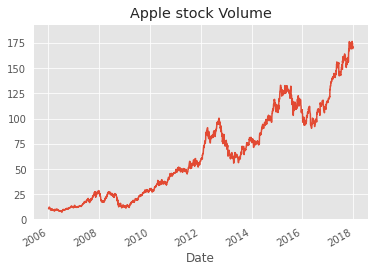

In [ ]:
plt.style.use('ggplot')
plt.ylim(0, max(df['Close']) * 1.1)
df['Close'].plot(label='CLOSE', title='Apple stock Volume')

In [ ]:
X = df.iloc[:, :-3]
y = df.iloc[:, -3:-2] 

In [ ]:
y

,Close
Date,
2006-01-03,10.68
2006-01-04,10.71
2006-01-05,10.63
2006-01-06,10.90
2006-01-09,10.86
...,...
2017-12-22,175.01
2017-12-26,170.57
2017-12-27,170.60


In [ ]:
X

,Open,High,Low
Date,,,
2006-01-03,10.34,10.68,10.32
2006-01-04,10.73,10.85,10.64
2006-01-05,10.69,10.70,10.54
2006-01-06,10.75,10.96,10.65
2006-01-09,10.96,11.03,10.82
...,...,...,...
2017-12-22,174.68,175.42,174.50
2017-12-26,170.80,171.47,169.68
2017-12-27,170.10,170.78,169.71


In [87]:
x = x_train
y = y_train_lstm

In [ ]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
mm = MinMaxScaler()
ss = StandardScaler()


X_ss = ss.fit_transform(X)
y_mm = mm.fit_transform(y) 

In [ ]:
#first 2200 for training

X_train = X_ss[:2200, :]
X_test = X_ss[2200:, :]

y_train = y_mm[:2200, :]
y_test = y_mm[2200:, :] 

In [91]:
X_train = x_train
y_train = y_train_lstm
X_test = x_test
y_test = y_test_lstm

In [92]:
print("Training Shape", X_train.shape, y_train.shape)
print("Testing Shape", X_test.shape, y_test.shape) 

Training Shape torch.Size([2399, 19, 1]) torch.Size([2399, 1])
Testing Shape torch.Size([600, 19, 1]) torch.Size([600, 1])


In [93]:
# Split the data into training and testing sets
train_data = TensorDataset(X_train, y_train)
test_data = TensorDataset(X_test, y_test)

train_loader = DataLoader(train_data, batch_size=1, shuffle=True)
test_loader = DataLoader(test_data, batch_size=1, shuffle=False)

In [90]:
# Split the data into training and testing sets
train_data = TensorDataset(torch.from_numpy(X_train), torch.from_numpy(y_train))
test_data = TensorDataset(torch.from_numpy(X_test), torch.from_numpy(y_test))

train_loader = DataLoader(train_data, batch_size=1, shuffle=True)
test_loader = DataLoader(test_data, batch_size=1, shuffle=False)

TypeError: ignored

In [94]:
# Initialize the LSTM model
# Define the input size, hidden size and number of outputs
input_size = 1
hidden_size = 32
output_size = 1
num_epochs= 10

# Define the LSTM model and Linear output fully connected layer
lstm = nn.LSTM(input_size, hidden_size, 2, batch_first=True)
fc = nn.Linear(hidden_size, output_size)

# Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.SGD(lstm.parameters(), lr=0.01)

/usr/local/lib/python3.8/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([2, 1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


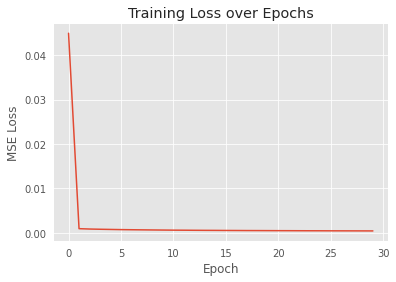

In [96]:
# Initializing Hyperparameters
num_epochs = 30
train_losses = []
test_losses = []

# Loop over the number of epochs
for epoch in range(num_epochs):
    train_loss = 0
    # Initialize the hidden state and the cell state
    # The hidden state and the cell state reset to zero for every epoch
    hs = torch.zeros(2, 1, hidden_size)
    cs = torch.zeros(2, 1, hidden_size)

    # Get the input and target at position i
    for i, (data, label) in enumerate(train_loader):
        
        hidden = (hs, cs)
        # Run the forward pass
        output, hidden = lstm(data.float(), hidden)
        output = fc(hidden[-1])
        hs = hs.detach()
        cs = cs.detach()

        # 2. Network Evaluation
        loss = criterion(output, label.float())

        # 3. Gradient Calculation
        loss.backward()

        # 4. Back Propagation
        optimizer.step()
        optimizer.zero_grad()

        train_loss += loss.item()

    # Calculate the average training loss
    train_loss = train_loss / len(train_loader)
    train_losses.append(train_loss)

# Plot the MSE loss for each epoch
plt.plot(train_losses)
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Training Loss over Epochs')
plt.show()

In [97]:
# Evaluate the LSTM model
mse = 0

#By wrapping the evaluation code in a with torch.no_grad() context, 
#you can avoid unnecessary memory usage and speed up the evaluation process.
with torch.no_grad():
    # Initialize the hidden state and the cell state
    # The hidden state and the cell state reset to zero for every epoch
    hs = torch.zeros(2, 1, hidden_size)
    cs = torch.zeros(2, 1, hidden_size)

    for data, label in test_loader:
        hidden = (hs, cs)
        output, hidden = lstm(data.float(), hidden)
        output = fc(hidden[-1])
        hs = hs.detach()
        cs = cs.detach()
        
        mse += ((output - label)**2).mean().item()

mse /= len(test_loader)
print('Test MSE: {}'.format(mse))

Test MSE: 0.007164189156724253


In [99]:
output_list = []

# Initialize the hidden state and the cell state
# The hidden state and the cell state reset to zero for every epoch
hs = torch.zeros(2, 1, hidden_size)
cs = torch.zeros(2, 1, hidden_size)
for i, (data, label) in enumerate(test_loader):
    hidden = (hs, cs)
    
    # Run the forward pass
    output, hidden = lstm(data.float(), hidden)
    output = fc(hidden[-1])
    hs = hs.detach()
    cs = cs.detach()
    output_list.append(output.detach().numpy()[0][0])
    
for i, (data, label) in enumerate(train_loader):
    hidden = (hs, cs)

    # Run the forward pass
    output, hidden = lstm(data.float(), hidden)
    output = fc(hidden[-1])
    hs = hs.detach()
    cs = cs.detach()
    output_list.append(output.detach().numpy()[0][0])

In [114]:
data_predict[0]

array([55.91329228])

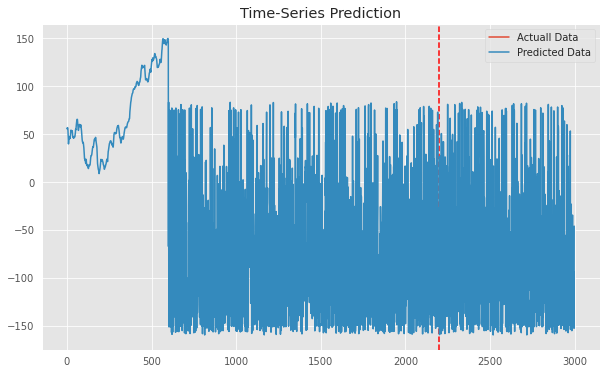

In [116]:
# train_predict = lstm(X_ss)#forward pass
# data_predict = train_predict.data.numpy() #numpy conversion
dataY_plot = y_test[0]
# data_predict = output_list

data_predict = mm.inverse_transform([output_list][0]) #reverse transformation
# dataY_plot = mm.inverse_transform(dataY_plot)
plt.figure(figsize=(10,6)) #plotting
plt.axvline(x=2200, c='r', linestyle='--') #size of the training set

plt.plot(dataY_plot, label='Actuall Data') #actual plot
plt.plot(data_predict, label='Predicted Data') #predicted plot
plt.title('Time-Series Prediction')
plt.legend()
plt.show() 

In [ ]:
# Save the trained RNN model
torch.save(lstm.state_dict(), 'lstm.pt')

# Load the model
rnn = nn.LSTM(input_size, hidden_size, batch_first=True)
rnn.load_state_dict(torch.load('lstm.pt'))

<All keys matched successfully>

# Second hamid LSTM trial, changing parameters

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('https://raw.githubusercontent.com/CNielsen94/NN_exercises_AAUBSDS/main/Assignment%202%20-%20CNN%20and%20RNN/AAPL_2006-01-01_to_2018-01-01.csv', index_col = 'Date', parse_dates=True)

In [ ]:
df.head()

,Open,High,Low,Close,Volume,Name
Date,,,,,,
2006-01-03,10.34,10.68,10.32,10.68,201853036,AAPL
2006-01-04,10.73,10.85,10.64,10.71,155225609,AAPL
2006-01-05,10.69,10.70,10.54,10.63,112396081,AAPL
2006-01-06,10.75,10.96,10.65,10.90,176139334,AAPL
2006-01-09,10.96,11.03,10.82,10.86,168861224,AAPL


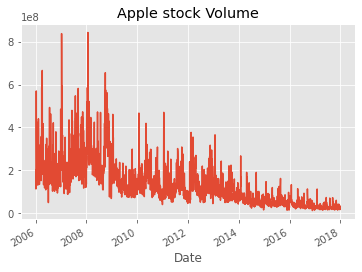

In [ ]:
plt.style.use('ggplot')
df['Volume'].plot(label='CLOSE', title='Apple stock Volume')

In [ ]:
X = df.iloc[:, :-2]
y = df.iloc[:, 4:5] 

In [ ]:
y

In [ ]:
X

In [ ]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
mm = MinMaxScaler()
ss = StandardScaler()


X_ss = ss.fit_transform(X)
y_mm = mm.fit_transform(y) 

In [ ]:
#first 2200 for training

X_train = X_ss[:2500, :]
X_test = X_ss[2500:, :]

y_train = y_mm[:2500, :]
y_test = y_mm[2500:, :] 

In [ ]:
print("Training Shape", X_train.shape, y_train.shape)
print("Testing Shape", X_test.shape, y_test.shape) 

Training Shape (2500, 4) (2500, 1)
Testing Shape (519, 4) (519, 1)


In [ ]:
# Split the data into training and testing sets
train_data = TensorDataset(torch.from_numpy(X_train), torch.from_numpy(y_train))
test_data = TensorDataset(torch.from_numpy(X_test), torch.from_numpy(y_test))

train_loader = DataLoader(train_data, batch_size=1, shuffle=True)
test_loader = DataLoader(test_data, batch_size=1, shuffle=False)

In [ ]:
# Initialize the LSTM model
# Define the input size, hidden size and number of outputs
input_size = 4
hidden_size = 6
output_size = 1
num_epochs= 5

# Define the LSTM model and Linear output fully connected layer
lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
fc = nn.Linear(hidden_size, output_size)

# Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.SGD(lstm.parameters(), lr=0.01)

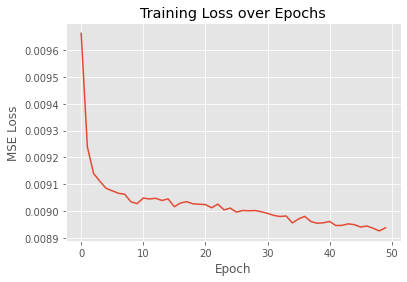

In [ ]:
# Initializing Hyperparameters
num_epochs = 50
train_losses = []
test_losses = []

# Loop over the number of epochs
for epoch in range(num_epochs):
    train_loss = 0
    # Initialize the hidden state and the cell state
    # The hidden state and the cell state reset to zero for every epoch
    hs = torch.zeros(1, hidden_size)
    cs = torch.zeros(1, hidden_size)

    # Get the input and target at position i
    for i, (data, label) in enumerate(train_loader):
        
        hidden = (hs, cs)
        # Run the forward pass
        output, hidden = lstm(data.float(), hidden)
        output = fc(hidden[-1])
        hs = hs.detach()
        cs = cs.detach()

        # 2. Network Evaluation
        loss = criterion(output, label.float())

        # 3. Gradient Calculation
        loss.backward()

        # 4. Back Propagation
        optimizer.step()
        optimizer.zero_grad()

        train_loss += loss.item()

    # Calculate the average training loss
    train_loss = train_loss / len(train_loader)
    train_losses.append(train_loss)

# Plot the MSE loss for each epoch
plt.plot(train_losses)
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Training Loss over Epochs')
plt.show()

In [ ]:
# Evaluate the LSTM model
mse = 0

#By wrapping the evaluation code in a with torch.no_grad() context, 
#you can avoid unnecessary memory usage and speed up the evaluation process.
with torch.no_grad():
    # Initialize the hidden state and the cell state
    # The hidden state and the cell state reset to zero for every epoch
    hs = torch.zeros(1, hidden_size)
    cs = torch.zeros(1, hidden_size)

    for data, label in test_loader:
        hidden = (hs, cs)
        output, hidden = lstm(data.float(), hidden)
        output = fc(hidden[-1])
        hs = hs.detach()
        cs = cs.detach()
        
        mse += ((output - label)**2).mean().item()

mse /= len(test_loader)
print('Test MSE: {}'.format(mse))

Test MSE: 0.001265097954979077


In [ ]:
output_list = []

# Initialize the hidden state and the cell state
# The hidden state and the cell state reset to zero for every epoch
hs = torch.zeros(1, hidden_size)
cs = torch.zeros(1, hidden_size)
for i, (data, label) in enumerate(test_loader):
    hidden = (hs, cs)
    
    # Run the forward pass
    output, hidden = lstm(data.float(), hidden)
    output = fc(hidden[-1])
    hs = hs.detach()
    cs = cs.detach()
    output_list.append(output.detach().numpy()[0][0])
    
for i, (data, label) in enumerate(train_loader):
    hidden = (hs, cs)

    # Run the forward pass
    output, hidden = lstm(data.float(), hidden)
    output = fc(hidden[-1])
    hs = hs.detach()
    cs = cs.detach()
    output_list.append(output.detach().numpy()[0][0])

In [ ]:
data_predict[0]

In [ ]:
# train_predict = lstm(X_ss)#forward pass
# data_predict = train_predict.data.numpy() #numpy conversion
# dataY_plot = y.Volume.values
# data_predict = output_list

data_predict = mm.inverse_transform([output_list]) #reverse transformation
dataY_plot = mm.inverse_transform(dataY_plot)
plt.figure(figsize=(10,6)) #plotting
plt.axvline(x=2500, c='r', linestyle='--') #size of the training set

plt.plot(dataY_plot, label='Actuall Data') #actual plot
plt.plot(data_predict[0], label='Predicted Data') #predicted plot
plt.title('Time-Series Prediction')
plt.legend()
plt.show() 

AttributeError: ignored

In [ ]:
# Save the trained RNN model
torch.save(lstm.state_dict(), 'lstm.pt')

# Load the model
rnn = nn.LSTM(input_size, hidden_size, batch_first=True)
rnn.load_state_dict(torch.load('lstm.pt'))